In [1]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

d:\Skripsi\Location Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = 'test.csv'  
data = pd.read_csv(path)
print(data.shape)

(1984, 13)


In [3]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

In [4]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

In [5]:
# Define a mapping for BSSID and corresponding transmit power
bssid_to_transmit_power = {
    1: 23,  # AP Dosen
    2: 23,  # AP Dosen
    3: 26,  # AP Digilab
    4: 26   # AP Digilab
}

# Add the 'transmit_power' column based on BSSID
data['transmit_power'] = data['bssid'].map(bssid_to_transmit_power)

data.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss,ap_x,ap_y,distance,transmit_power
1321,41,3,2,1,2454,1037,-200.0,-64.0,1,20,2314,468,585.970136,23
76,2,18,4,11,300,1567,-63.0,-200.0,0,10,870,1122,723.135534,26
530,30,6,3,11,989,1202,-42.0,-200.0,1,0,870,1122,143.391074,26
629,37,11,4,11,1908,1037,-53.0,-200.0,1,0,870,1122,1041.474436,26
1503,39,10,3,11,2224,1037,-61.0,-200.0,1,0,870,1122,1356.665397,26


## Scaling using Robust Scaler


In [6]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['reference_point', 'iteration', 'bssid', 'channel', 'xr', 'yr',
       'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'obstacle_loss', 'ap_x', 'ap_y', 'distance', 'transmit_power'],
      dtype='object')
Shape of DataFrame: (1984, 14)


In [7]:
df = data.iloc[:, [1, 2, 3, 4, 7, 8, 11]]
print("\nColumns in X:", df.columns.tolist())

df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['iteration', 'bssid', 'channel', 'xr', 'rssi_ap_dosen', 'relative_position', 'ap_y']


                   iteration     bssid   channel        xr  rssi_ap_dosen  \
iteration           1.000000 -0.012741 -0.009956  0.004220       0.009336   
bssid              -0.012741  1.000000  0.878881 -0.311043      -0.874879   
channel            -0.009956  0.878881  1.000000 -0.355584      -0.995611   
xr                  0.004220 -0.311043 -0.355584  1.000000       0.392163   
rssi_ap_dosen       0.009336 -0.874879 -0.995611  0.392163       1.000000   
relative_position  -0.001582 -0.385365 -0.439201  0.790541       0.448530   
ap_y               -0.009956  0.878881  1.000000 -0.355584      -0.995611   

                   relative_position      ap_y  
iteration                  -0.001582 -0.009956  
bssid                      -0.385365  0.878881  
channel                    -0.439201  1.000000  
xr                          0.790541 -0.355584  
rssi_ap_dosen               0.448530 -0.995611  
relative_position           1.000000 -0.439201  
ap_y                       -0.439201  1.

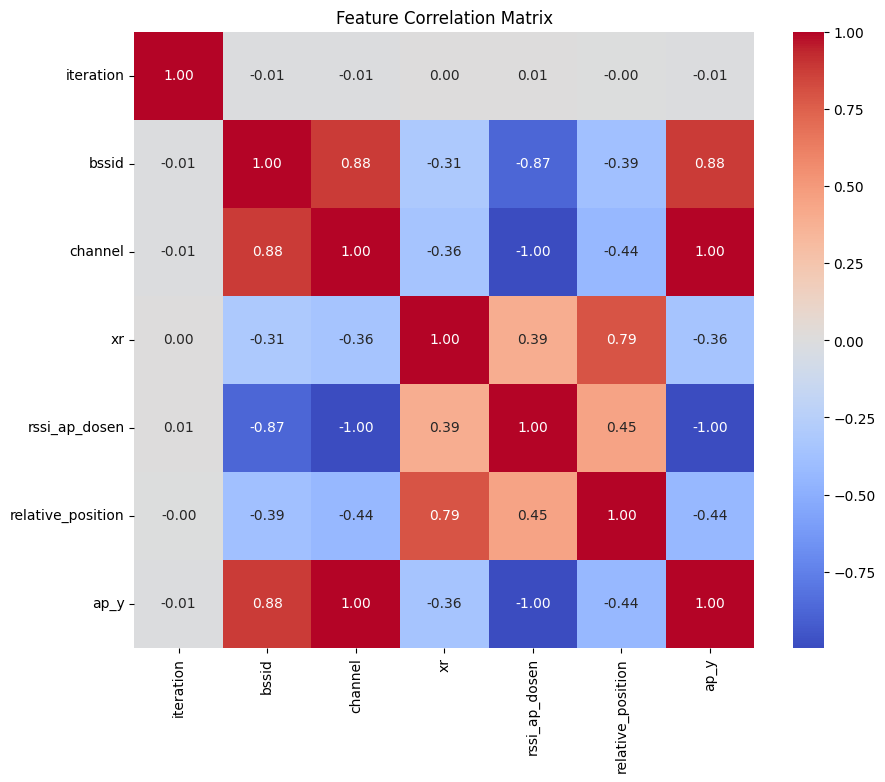

In [8]:
import pandas as pd
import numpy as np

# Compute correlation matrix
correlation_matrix = df.corr(method='pearson')  # Use 'spearman' for rank correlation

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [9]:
df

,iteration,bssid,channel,xr,rssi_ap_dosen,relative_position,ap_y
0,3,4,11,300,-200.0,0,1122
1,1,3,11,300,-200.0,0,1122
2,1,4,11,300,-200.0,0,1122
3,2,4,11,300,-200.0,0,1122
4,2,3,11,300,-200.0,0,1122
...,...,...,...,...,...,...,...
1979,19,2,1,1219,-83.0,1,468
1980,20,4,11,1219,-200.0,1,1122
1981,20,3,11,1219,-200.0,1,1122
1982,20,1,1,1219,-83.0,1,468


### Are there overlapping points?

In [10]:
# binned_data = df.copy()
# binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
# overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
# overlapping_points = overlapping_points[overlapping_points > 1]
# overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

# overlapping_data

In [11]:
# # delete overlapping data 
# non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
# df = df[non_overlapping_mask]
# df.shape

## Regression Model

In [12]:
data.columns.tolist()

['reference_point',
 'iteration',
 'bssid',
 'channel',
 'xr',
 'yr',
 'rssi_ap_digilab',
 'rssi_ap_dosen',
 'relative_position',
 'obstacle_loss',
 'ap_x',
 'ap_y',
 'distance',
 'transmit_power']

In [13]:
X = data.iloc[:, [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]]
y = data.iloc[:, [5, 6]]

In [14]:
data.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss,ap_x,ap_y,distance,transmit_power
1535,39,18,1,1,2224,1037,-200.0,-70.0,1,20,2314,468,576.073780,23
1118,38,11,2,1,1908,1202,-200.0,-81.0,1,20,2314,468,838.803910,23
727,11,19,4,11,759,1368,-62.0,-200.0,0,5,870,1122,269.883308,26
1969,31,17,3,11,1219,1037,-43.0,-200.0,1,0,870,1122,359.201893,26
1801,34,15,3,11,1449,1202,-48.0,-200.0,1,0,870,1122,584.500642,26


In [15]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'xr', 'yr', 'relative_position', 'obstacle_loss', 'ap_x', 'ap_y']
Columns in y: ['yr', 'rssi_ap_digilab']


In [16]:
print(X.head())
print(X.dtypes)

   reference_point  iteration  bssid  channel   xr    yr  relative_position  \
0                1          3      4       11  300  1368                  0   
1                1          1      3       11  300  1368                  0   
2                1          1      4       11  300  1368                  0   
3                1          2      4       11  300  1368                  0   
4                1          2      3       11  300  1368                  0   

   obstacle_loss  ap_x  ap_y  
0             10   870  1122  
1             10   870  1122  
2             10   870  1122  
3             10   870  1122  
4             10   870  1122  
reference_point      int64
iteration            int64
bssid                int64
channel              int64
xr                   int64
yr                   int64
relative_position    int64
obstacle_loss        int64
ap_x                 int64
ap_y                 int64
dtype: object


In [17]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [18]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'xr', 'yr', 'relative_position', 'obstacle_loss', 'ap_x', 'ap_y']
Columns in y: ['yr', 'rssi_ap_digilab']


In [19]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Assuming X and y are preprocessed and split-ready
# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(regression_data_scaled, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Random Forest Regressor with a specified number of trees
n_trees = 100  # You can adjust this based on your data for optimal performance
rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 1.5466
Root Mean Squared Error (RMSE): 1.2436
Mean Absolute Error (MAE): 0.4528
R² Score: 0.9996


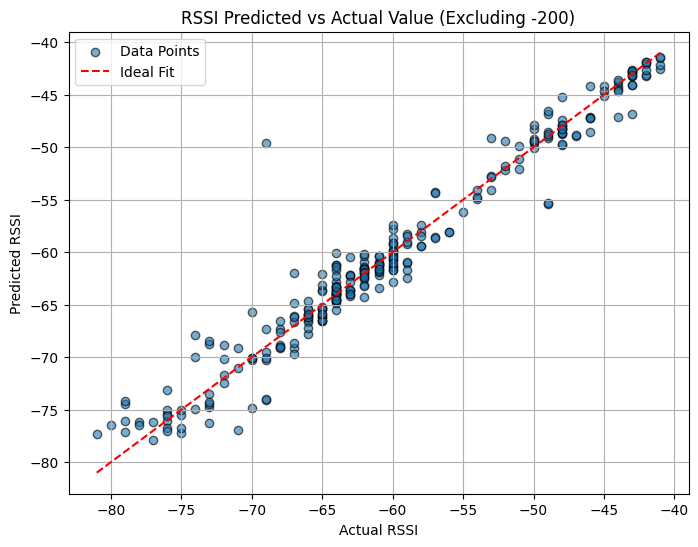

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Combine RSSI data for Digilab and Dosen into single arrays
combined_actual = np.concatenate([y_test[:, 0], y_test[:, 1]])
combined_predicted = np.concatenate([y_pred[:, 0], y_pred[:, 1]])

# Filter out data points where actual or predicted RSSI equals -200
mask = (combined_actual != -200) & (combined_predicted != -200) & (combined_predicted <= 1)
filtered_actual = combined_actual[mask]
filtered_predicted = combined_predicted[mask]

# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(filtered_actual, filtered_predicted, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([filtered_actual.min(), filtered_actual.max()],
         [filtered_actual.min(), filtered_actual.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("RSSI Predicted vs Actual Value (Excluding -200)")
plt.xlabel("Actual RSSI")
plt.ylabel("Predicted RSSI")
plt.grid(True)
plt.legend()
plt.show()


In [33]:
xr = X_test[:, X.columns.get_loc('xr')]  # Assuming 'rssi_ap_digilab' is one of the feature columns
yr = X_test[:, X.columns.get_loc('yr')]  # Assuming 'rssi_ap_dosen' is one of the feature columns

# Create the comparison dataframe with the actual and predicted coordinates
comparison_df = pd.DataFrame({
    'xr': xr,  # Adding RSSI for digilab
    'yr': yr,  # Adding RSSI for dosen
    'actual_rssi_digilab': y_test[:, 0],  # Actual x-coordinate
    'predicted_rssi_digilab': y_pred[:, 0],  # Predicted x-coordinate
    'actual_rssi_dosen': y_test[:, 1],  # Actual y-coordinate
    'predicted_rssi_dosen': y_pred[:, 1]  # Predicted y-coordinate
})

# Display the comparison table
comparison_df.sample(10)

,xr,yr,actual_rssi_digilab,predicted_rssi_digilab,actual_rssi_dosen,predicted_rssi_dosen
270,0.000000,0.000000,1202.0,1202.0,-42.0,-41.90
322,-0.749728,1.407547,1948.0,1948.0,-200.0,-200.00
373,-0.250272,0.313208,1368.0,1368.0,-57.0,-58.65
262,0.000000,1.032075,1749.0,1749.0,-62.0,-61.59
153,-0.500544,0.688679,1567.0,1567.0,-62.0,-63.12
63,0.000000,1.750943,2130.0,2130.0,-81.0,-77.34
6,1.000000,-0.311321,1037.0,1037.0,-200.0,-200.00
12,0.250272,-0.311321,1037.0,1037.0,-43.0,-42.87
378,0.000000,0.000000,1202.0,1202.0,-200.0,-200.00
191,-0.250272,0.313208,1368.0,1368.0,-200.0,-200.00


In [24]:
data.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss,ap_x,ap_y,distance,transmit_power
1666,33,1,3,11,1449,1037,-48.0,-200.0,1,0,870,1122,585.205947,26
1827,32,1,1,1,1219,1202,-200.0,-94.0,1,20,2314,468,1318.249218,23
1212,36,15,2,1,1678,1202,-200.0,-86.0,1,20,2314,468,971.211614,23
1235,42,1,1,1,2454,1202,-200.0,-70.0,1,20,2314,468,747.232226,23
1377,41,18,3,11,2454,1037,-62.0,-200.0,1,0,870,1122,1586.278979,26


# Genetic Algorithms

In [25]:
import numpy as np
import itertools
import pandas as pd

# Define the possible transmit power levels for each AP (in dBm)
ap_digilab_power_levels = [20, 23, 26, 30] 
ap_dosen_power_levels = [20, 23, 26, 30] 

# Generate all combinations of transmit power settings
power_combinations = list(itertools.product(ap_digilab_power_levels, ap_dosen_power_levels))

# Initialize a results list
results = []

# Process each iteration group
for iteration, group in data.groupby('iteration'):
    for index, row in group.iterrows():
        best_rssi = -float('inf')
        best_combination = None
        
        # Evaluate each power combination
        for digilab_power, dosen_power in power_combinations:
            # Simulate RSSI adjustment (example logic)
            rssi_digilab = row['rssi_ap_digilab'] + (digilab_power - row['transmit_power'])
            rssi_dosen = row['rssi_ap_dosen'] + (dosen_power - row['transmit_power'])
            
            # Determine which AP the user connects to
            if rssi_digilab > rssi_dosen:
                selected_rssi = rssi_digilab
                selected_ap = 'digilab'
            else:
                selected_rssi = rssi_dosen
                selected_ap = 'dosen'
            
            # Check if this combination is the best so far
            if selected_rssi > best_rssi:
                best_rssi = selected_rssi
                best_combination = (digilab_power, dosen_power)
        
        # Store the result for this reference point
        results.append({
            'reference_point': row['reference_point'],
            'iteration': iteration,
            'best_rssi': best_rssi,
            'best_combination': best_combination,
            'observed_rssi': row['rssi_ap_digilab'] if selected_ap == 'digilab' else row['rssi_ap_dosen'],
            'predicted_rssi': best_rssi
        })

# Create a results DataFrame
results_df = pd.DataFrame(results)

# Find the overall best combination and RSSI
overall_best = results_df.loc[results_df['best_rssi'].idxmax()]
print(f"Best Transmit Power Combination: {overall_best['best_combination']}")
print(f"Maximum RSSI: {overall_best['best_rssi']}")

# Error Metrics Calculation
def calculate_error_metrics(observed, predicted):
    """
    Calculate MAE, RMSE, and MBE for observed and predicted RSSI values.

    Parameters:
        observed (list or numpy array): Actual RSSI values.
        predicted (list or numpy array): Predicted RSSI values.

    Returns:
        dict: A dictionary containing MAE, RMSE, and MBE.
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(observed - predicted))
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    
    # Calculate Mean Bias Error (MBE)
    mbe = np.mean(predicted - observed)
    
    return {"MAE": mae, "RMSE": rmse, "MBE": mbe}

# Calculate error metrics
errors = calculate_error_metrics(results_df['observed_rssi'], results_df['predicted_rssi'])

# Print the error metrics
print("\nError Metrics:")
print(f"Mean Absolute Error (MAE): {errors['MAE']}")
print(f"Root Mean Squared Error (RMSE): {errors['RMSE']}")
print(f"Mean Bias Error (MBE): {errors['MBE']}")


Best Transmit Power Combination: (30, 20)
Maximum RSSI: -35.0

Error Metrics:
Mean Absolute Error (MAE): 4.902721774193548
Root Mean Squared Error (RMSE): 5.092144883654533
Mean Bias Error (MBE): 4.902721774193548
